In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv(r"raw.csv")

In [ ]:
df.head()

,class,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [4]:
df.shape

(56745, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56745 entries, 0 to 56744
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   56745 non-null  int64 
 1   tweet   56745 non-null  object
dtypes: int64(1), object(1)
memory usage: 886.8+ KB


In [6]:
df.isnull().sum()

class    0
tweet    0
dtype: int64

In [7]:
df.duplicated().sum()

2432

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.duplicated().sum()

0

<Axes: xlabel='class', ylabel='count'>

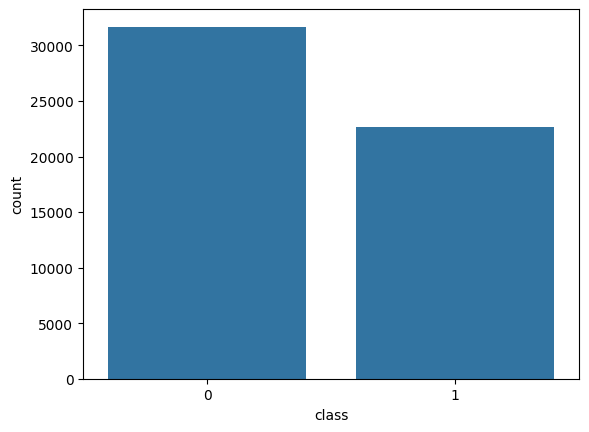

In [10]:
sns.countplot(x='class',data=df)

# Preprocessing

In [11]:
import re
import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
# let's apply stemming and stopwords on the data
stemmer = nltk.SnowballStemmer('english')
stopword=set(stopwords.words('english'))

In [13]:
# Let's apply regex and do cleaning.
def data_cleaning(words):
    words = str(words).lower()
    words = re.sub('', '', words)
    words = re.sub('https?://\S+|www\.\S+', '', words)
    words = re.sub('<.*?>+', '', words)
    words = re.sub('[%s]' % re.escape(string.punctuation), '', words)
    words = re.sub('\n', '', words)
    words = re.sub('\w*\d\w*', '', words)
    words = [word for word in words.split(' ') if words not in stopword]
    words=" ".join(words)
    words = [stemmer.stem(words) for word in words.split(' ')]
    words=" ".join(words)

    return words

In [14]:
# let's apply data_cleaning on the data
df['tweet'] = df['tweet'].apply(data_cleaning)

In [15]:
df['tweet'][0]

' user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run  user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run  user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run  user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run  user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run  user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run  user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run  user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run  user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run  user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run

In [17]:
x= df['tweet']
y= df['class']

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [21]:
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train.shape)

(43450,)
(10863,)
(10863,)
(43450,)


# Feature Engineering

In [22]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [23]:
max_words = 50000
max_len = 300

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [24]:
sequences_matrix

array([[    0,     0,     0, ...,  2541,   183,  8427],
       [    0,     0,     0, ...,    22, 11876,  2251],
       [  124,    31,     1, ...,  9663, 27975,   105],
       ...,
       [    0,     0,     0, ...,     2,   551,   113],
       [    0,     0,     0, ...,     3, 34777,  1566],
       [    0,     0,     0, ...,  1275,    51,    18]], dtype=int32)

In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop

In [26]:
# Creating model architecture.
model = Sequential()
model.add(Embedding(max_words,100,input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 300, 100)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5080501 (19.38 MB)
Trainable params: 5080501 (19.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [28]:
# starting model training
history = model.fit(sequences_matrix,y_train,batch_size=128,epochs = 1,validation_split=0.2)

272/272 [==============================] - 404s 1s/step - loss: 0.2842 - accuracy: 0.8884 - val_loss: 0.1886 - val_accuracy: 0.9313


In [29]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [30]:
# Model evaluation
accr = model.evaluate(test_sequences_matrix,y_test)

340/340 [==============================] - 35s 103ms/step - loss: 0.1849 - accuracy: 0.9338


In [31]:
lstm_prediction = model.predict(test_sequences_matrix)

340/340 [==============================] - 34s 100ms/step


In [32]:
res = []
for prediction in lstm_prediction:
    if prediction[0] < 0.5:
        res.append(0)
    else:
        res.append(1)

In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
print(confusion_matrix(y_test,res))

[[6003  288]
 [ 431 4141]]


In [35]:
print(confusion_matrix(y_test,res))

[[6003  288]
 [ 431 4141]]


In [36]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
# Let's save the mdoel.
model.save("model.h5")

In [38]:
# Let's test our model on custom data.
test = 'i love this movie'

def clean_text(text):
    print(text)
    text = str(text).lower()
    text = re.sub('', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print(text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

test=[clean_text(test)]
print(test)

seq = tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)

pred = model.predict(padded)

print("pred", pred)
if pred<0.5:
    print("No hate")
else:
    print("Hate and abusive")

i love this movie
i love this movie
['love movi']
[[34, 5485]]
1/1 [==============================] - 0s 65ms/step
pred [[0.23196873]]
No hate
